In [22]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import collections
import os
import pickle

In [23]:
import tcri
from genevector.data import GeneVectorDataset
from genevector.model import GeneVector
from genevector.embedding import GeneEmbedding, CellEmbedding
import grimoire as spell

## Configuration

In [61]:
#any without signed mi were  false
disease            = "bcc"
subset             = "CD8"
signed_mi          = True
init_ortho         = True
entropy_threshold  = 1.
mutual_information = "/Users/ceglian/Data/tcri/{}_{}_{}_{}.p".format(disease,subset,signed_mi,str(entropy_threshold).replace(".",""))
print(mutual_information)
adata_h5ad         = "/Users/ceglian/Data/tcri/yost.h5ad"
embedding_size     = 100
alpha              = 0.00
beta               = 0.00
gain               = 10
c                  = 100
vector_file        = "/Users/ceglian/Data/tcri/{}_{}_{}_{}_{}_{}_{}_{}.vec".format(disease,embedding_size, alpha, beta, gain, subset, signed_mi, init_ortho)
print(vector_file)
retrain            = True
annotated_h5ad     = "/Users/ceglian/Data/tcri/{}_{}_annoated.h5ad".format(disease,subset)
device             = "cpu"


cd8 = ['CD8_act',
        'CD8_eff',
        'CD8_ex',
        'CD8_ex_act',
        'CD8_mem',
        'CD8_naive']
cd4 = ['Naive',
        'Tfh',
        'Th17',
        'Tregs']

/Users/ceglian/Data/tcri/bcc_CD8_True_10.p
/Users/ceglian/Data/tcri/bcc_100_0.0_0.0_10_CD8_True_True.vec


In [64]:

adata = sc.read(adata_h5ad)
adata = adata[adata.obs["disease"] == "bcc"]
set(adata.obs["cluster"])

{'CD8_act',
 'CD8_eff',
 'CD8_ex',
 'CD8_ex_act',
 'CD8_mem',
 'Naive',
 'Tfh',
 'Th17',
 'Tregs'}

## Read BCC data

In [63]:
adata = sc.read(adata_h5ad)
adata.X = csr_matrix(adata.X)
adata = adata[adata.obs["disease"] == "bcc"]
adata = spell.pp.remove_meaningless_genes(adata)

genes = [x for x in adata.var.index.tolist()]
genes = [x for x in genes if "TRAV" not in x]
genes = [x for x in genes if "TRAJ" not in x]
genes = [x for x in genes if "TRAD" not in x]


genes = [x for x in genes if "TRBV" not in x]
genes = [x for x in genes if "TRBJ" not in x]
genes = [x for x in genes if "TRBD" not in x]

genes = [x for x in genes if "TRGV" not in x]
genes = [x for x in genes if "TRGJ" not in x]
genes = [x for x in genes if "TRGD" not in x]

genes = [x for x in genes if "TRDV" not in x]
genes = [x for x in genes if "TRDJ" not in x]
genes = [x for x in genes if "TRDD" not in x]
adata = adata[:,genes]

tcri.pp.register_clonotype_key(adata,"trb")
adata = adata[adata.obs[adata.uns["tcri_clone_key"]]!="None"]
if subset == "CD8":
    adata = adata[adata.obs["cluster"].isin(cd8)]
    print(set(adata.obs["cluster"]))
else:
    adata = adata[adata.obs["cluster"].isin(cd4)]
adata
tcri.pp.gene_entropy(adata)
adata = adata[:,adata.var["entropy"] > entropy_threshold]
dataset = GeneVectorDataset(adata,load_expression=retrain,signed_mi=signed_mi,device=device)
adata

{'CD8_eff', 'CD8_ex', 'CD8_ex_act', 'CD8_mem', 'CD8_act'}


100%|██████████| 15828/15828 [00:01<00:00, 8819.29it/s]


Running...
Loading Expression.
Indexing expression.


100%|██████████| 4610016/4610016 [00:02<00:00, 1926270.66it/s]


Finished.


View of AnnData object with n_obs × n_vars = 9563 × 956
    obs: 'cell.id', 'patient', 'treatment', 'cluster', 'UMAP1', 'UMAP2', 'trb', 'trb2', 'disease', 'response'
    var: 'entropy'
    uns: 'cluster_colors', 'tcri_clone_key', 'tcri_unique_clonotypes'
    obsm: 'X_umap'

In [53]:
if retrain:
    if os.path.exists(mutual_information):
        print("hit")
        dataset.mi_scores = pickle.load(open(mutual_information,"rb"))
    print(len(dataset.mi_scores),len(adata.var.index))
    cmps = GeneVector(dataset,
                        output_file=vector_file,
                        emb_dimension=embedding_size,
                        gain=gain,
                        c=100,
                        init_ortho=init_ortho,
                        device=device)
    if not os.path.exists(mutual_information):
        pickle.dump(dict(dataset.mi_scores),open(mutual_information,"wb"))

hit
956 956
*****************
Loading Dataset.
*****************



100%|██████████| 956/956 [00:00<00:00, 5954.64it/s]

MI Loaded.
Loading Batches for Training.



100%|██████████| 956/956 [00:00<00:00, 1762.42it/s]


Ready to train.


Saving model...
Loading average of 1st and 2nd weights.


100%|██████████| 956/956 [00:00<00:00, 3900539.52it/s]


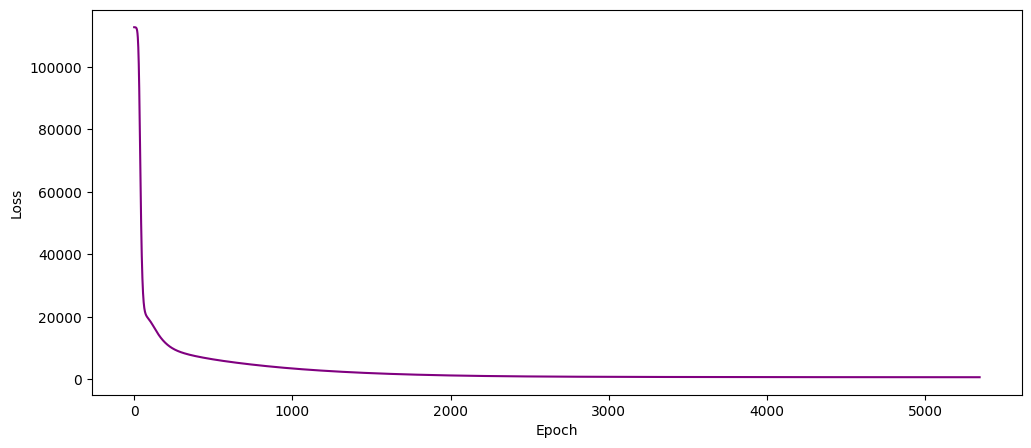

In [73]:
if retrain:
    cmps.train(1,threshold=1e-5,alpha=alpha, beta=beta, update_interval=100)
    embed = GeneEmbedding(vector_file, dataset, vector="average")
    cmps.plot()

In [74]:
embed = GeneEmbedding(vector_file, dataset, vector="average")
cembed = CellEmbedding(dataset, embed)
if True:
    cembed.batch_correct(column="patient",reference="su009")
adata = cembed.get_adata()
adata

Loading average of 1st and 2nd weights.


100%|██████████| 4610016/4610016 [00:07<00:00, 616909.42it/s]


Generating Cell Vectors.


100%|██████████| 9563/9563 [00:01<00:00, 6454.66it/s]


Found 0 Cells with No Counts.
Finished.
Generating batch vectors.
Computing correction vector for su001.
Computing correction vector for su002.
Computing correction vector for su003.
Computing correction vector for su004.
Computing correction vector for su005.
Computing correction vector for su006.
Computing correction vector for su007.
Computing correction vector for su008.
Computing correction vector for su010.
Computing correction vector for su012.
Applying correction vectors.
Loading embedding in X_genevector.
Running Scanpy neighbors and umap.


AnnData object with n_obs × n_vars = 9563 × 956
    obs: 'cell.id', 'patient', 'treatment', 'cluster', 'UMAP1', 'UMAP2', 'trb', 'trb2', 'disease', 'response'
    var: 'entropy'
    uns: 'cluster_colors', 'tcri_clone_key', 'tcri_unique_clonotypes', 'neighbors', 'umap'
    obsm: 'X_umap', 'X_genevector'
    obsp: 'distances', 'connectivities'

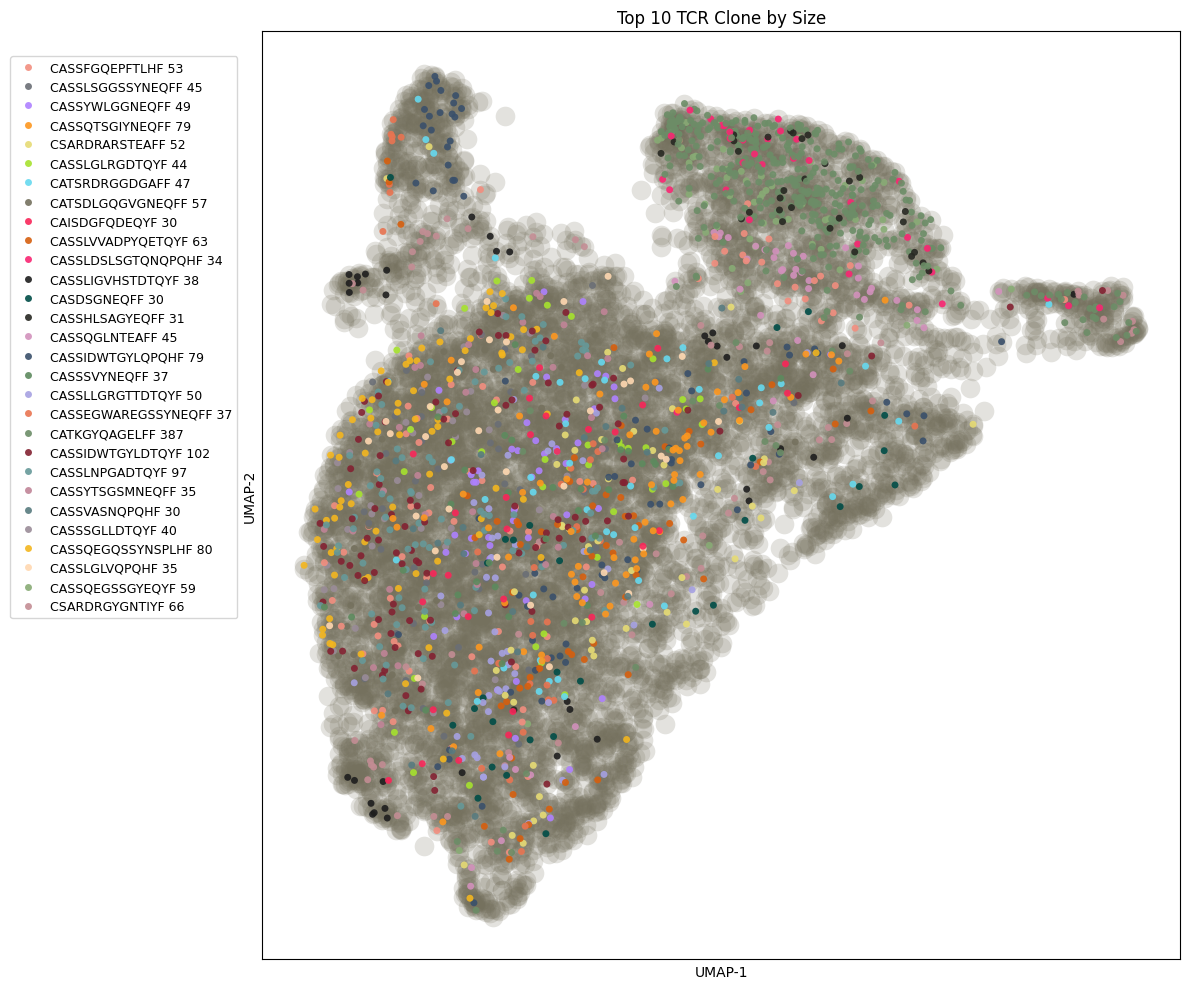

In [67]:
tcri.pl.top_clone_umap(adata,figsize=(12,10),top_n=30,bg_size=200,bg_alpha=0.2)

In [68]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

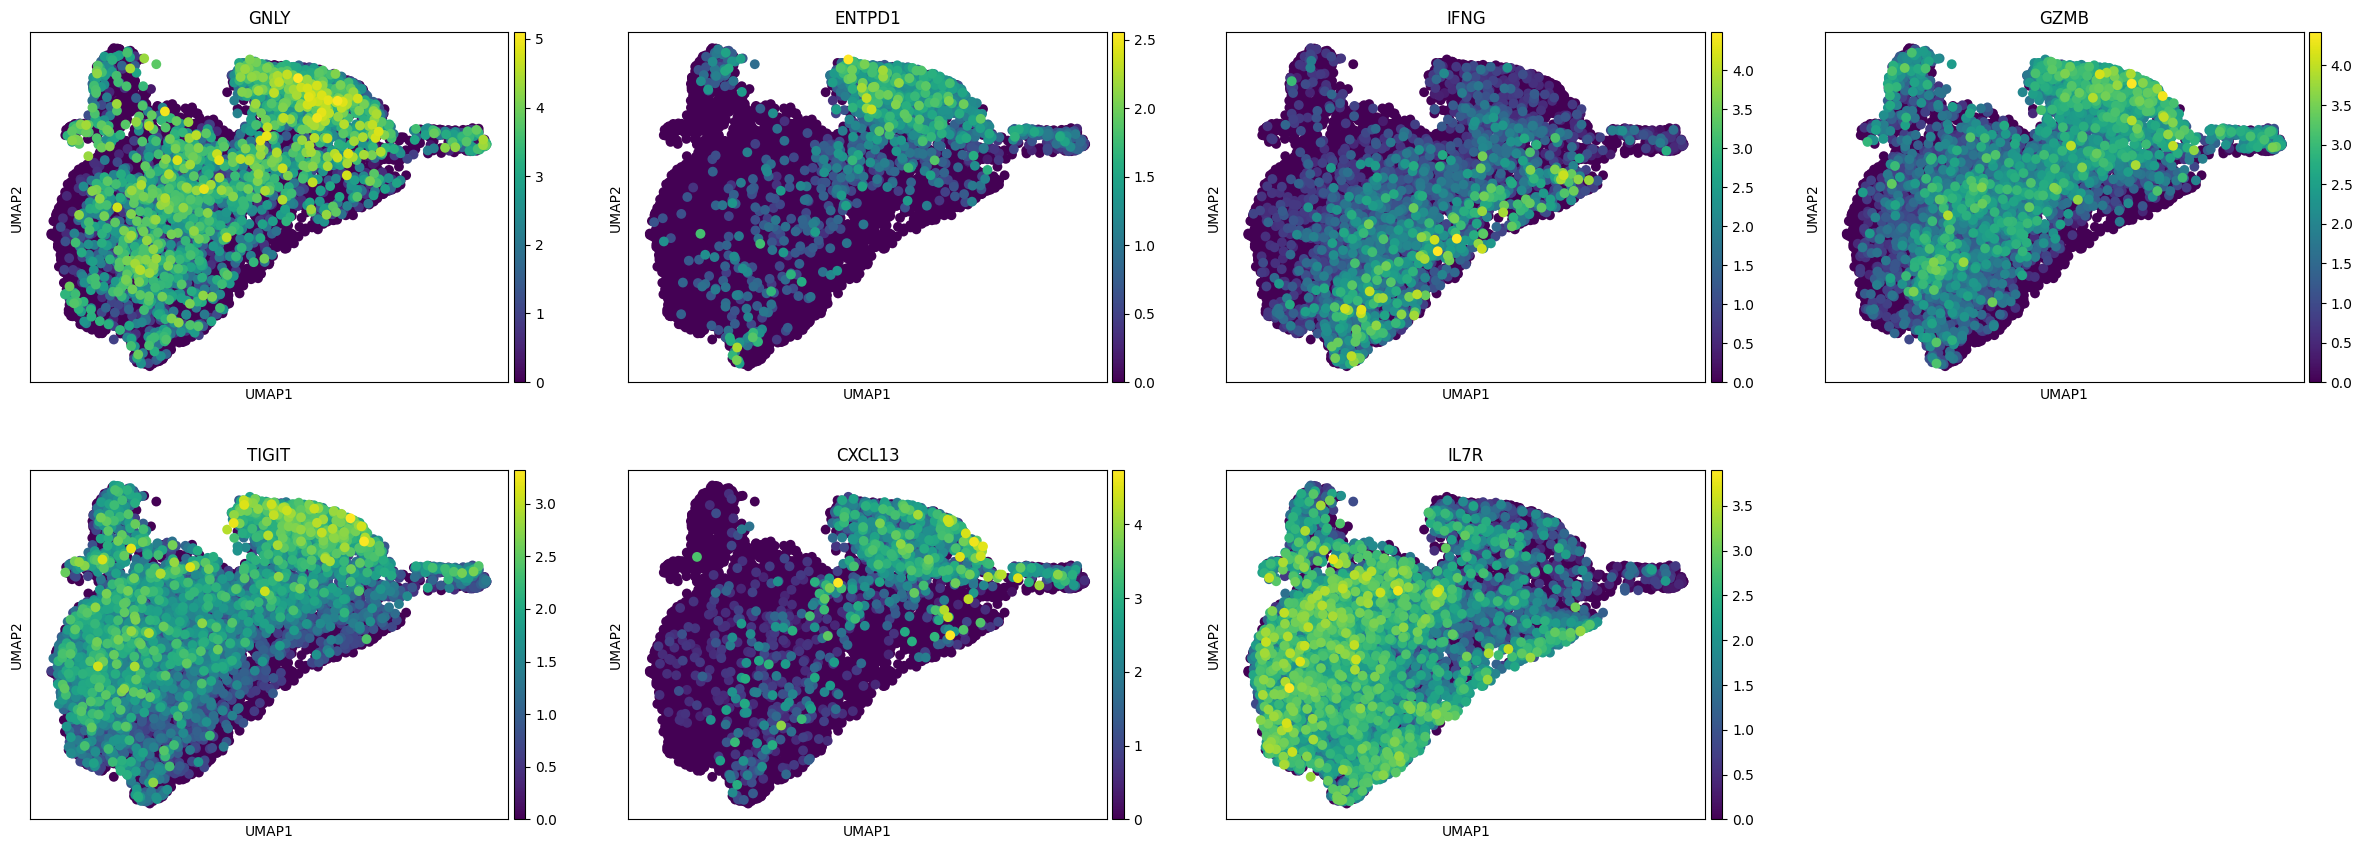

In [69]:
sc.pl.umap(adata,color=["GNLY","ENTPD1","IFNG","GZMB","TIGIT","CXCL13","IL7R"],s=200)

In [70]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas
import tqdm
import scanpy as sc
import networkx as nx
from sklearn.metrics import confusion_matrix
from scipy.special import softmax
from scipy.spatial import distance
import numpy
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from scipy.sparse import csr_matrix
import numpy as np
import operator
import collections
import os   
import pandas as pd
import gc
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import seaborn as sns

markers = dict()
markers["Naive"] = ["IL7R"]
markers["Activated"] = ["GZMB"]
markers["Memory"] = ["GZMK"]
markers["Dsyfunctional"] = ["CXCL13"]

def cell_distance(self, vec, norm=True):
    # matrix = self.matrix
    # if norm:
    #     vec /= np.linalg.norm(vec)
    #     print("norm")
    #     matrix = normalize(matrix)
    mapped_components = dict(zip(list(self.data.keys()),self.matrix))
    odists = []
    for x in tqdm.tqdm(self.adata.obs.index):
        cell_vec = mapped_components[x]
        # if norm:
        #     cell_vec /= np.linalg.norm(cell_vec)
        dist = 1. - distance.cosine(cell_vec, vec)
        odists.append(dist)
    return odists

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

from sklearn import preprocessing

def phenotype_probability(self, adata, phenotype_markers, return_distances=False, method="sparsemax", target_col="genevector", temperature=0.05, normalize=True):
    """
    Probablistically assign phenotypes based on a set of cell type labels and associated markers. 
    Can optionally return the original cosine distances and perform the assignment based on expression weight gene vectors.
    Loads into the anndata the pseudo-probabilities for each cell type and the deterministic label taken from the maximum probability over cell types.

    :param adata: anndata object generated from "get_adata", has "X_genevector" in the obsm dataframe.
    :type column: anndata.AnnData
    :param phenotype_markers: Dictionary of cell type labels (key) to gene markers used to define the cell type as a list (value).
    :type phenotype_markers: dict
    :param return_distances: Change the return type to a tuple that includes a dictionary containing the actual cosine distances alongside the phenotype probabilities.
    :type column: bool
    :param expression_weighted: Compute similarit to each cell using the expression weightedy marker gnene vector.
    :type column: bool
    :param target_col: Column label to load in deterministic cell asssignments in the obs data frame of the anndata object.
    :type target_col: bool
    :return: Anndata with cell type labels and probabilities, or optionally a tuple with the anndata and the raw cosine similarities.
    :rtype:  anndata.AnnData
    """
    if method == "softmax":
        print(bcolors.OKBLUE+"Using **SoftMax**"+bcolors.ENDC)
        pfunc = softmax
    elif method == "sparsemax":
        print(bcolors.OKBLUE+"Using **SparseMax**"+bcolors.ENDC)
        pfunc = self.entmax_15
    elif method == "normalized_exponential":
        print(bcolors.OKBLUE+"Using Normalized Exponential (Temp: {})".format(temperature)+bcolors.ENDC)
        pfunc = lambda x: self.normalized_exponential_vector(x, temperature)
    for x in adata.obs.columns:
        if "Pseudo-probability" in x:
            del adata.obs[x]
    mapped_components = dict(zip(list(self.data.keys()),self.matrix))
    genes = adata.var.index.to_list()
    cells = adata.obs.index.to_list()
    all_markers = []
    for _, markers in phenotype_markers.items():
        all_markers += markers  
    all_markers = list(set(all_markers))
    probs = dict()

    for pheno, markers in phenotype_markers.items():
        print(bcolors.OKBLUE+"Computing similarities for {}".format(pheno)+bcolors.ENDC)
        print(bcolors.OKGREEN+"Markers: {}".format(", ".join(markers))+bcolors.ENDC)
        vector = self.embed.generate_vector(markers)
        probs[pheno] = cell_distance(self, vector,norm=normalize)
    distribution = []
    celltypes = []
    for k, v in probs.items():
        distribution.append(v)
        celltypes.append(k)
    distribution = np.array(distribution)
    distribution = preprocessing.normalize(distribution)
    distribution = list(zip(*distribution))
    probabilities = []
    for d in distribution:
        p = pfunc(numpy.array(d))
        probabilities.append(p)
    
    res = {"distances":distribution, "order":celltypes, "probabilities":probabilities}
    barcode_to_label = dict(zip(list(self.data.keys()), res["probabilities"]))
    ct = []
    probs = collections.defaultdict(list)
    for x in adata.obs.index:
        ctx = res["order"][numpy.argmax(barcode_to_label[x])]
        ct.append(ctx)
        for ph, pb in zip(res["order"],barcode_to_label[x]):
            probs[ph].append(pb)
    adata.obs[target_col] = ct
    def load_predictions(adata,probs):
        prob_cols = []
        for ph in probs.keys():
            prob_cols.append(ph+" Pseudo-probability")
            adata.obs[ph+" Pseudo-probability"] = probs[ph]
        adata.uns["probability_columns"] = prob_cols
        return adata
    adata = load_predictions(adata, probs)
    if return_distances:
        return adata, res
    else:
        return adata

adata, dist = phenotype_probability(cembed, adata, markers, method="normalized_exponential", temperature=0.0001, return_distances=True, normalize=True)

Using Normalized Exponential (Temp: 0.0001)
Computing similarities for Naive
Markers: IL7R


100%|██████████| 9563/9563 [00:00<00:00, 65651.53it/s]


Computing similarities for Activated
Markers: GZMB


100%|██████████| 9563/9563 [00:00<00:00, 70394.83it/s]


Computing similarities for Memory
Markers: GZMK


100%|██████████| 9563/9563 [00:00<00:00, 70376.30it/s]


Computing similarities for Dsyfunctional
Markers: CXCL13


100%|██████████| 9563/9563 [00:00<00:00, 68419.53it/s]


<Axes: xlabel='genevector', ylabel='count'>

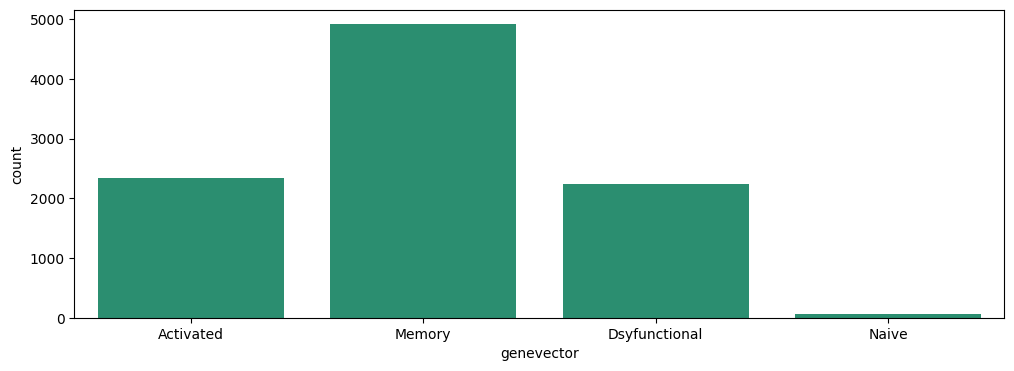

In [71]:
fig,ax=plt.subplots(1,1,figsize=(12,4))
sns.countplot(data=adata.obs, x="genevector",ax=ax)

<Axes: xlabel='genevector', ylabel='cluster'>

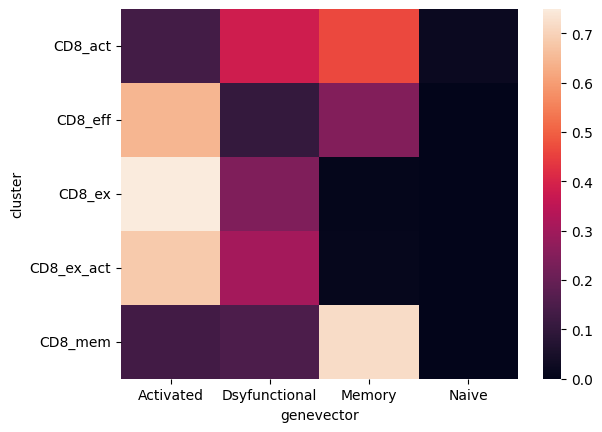

In [72]:

cembed.compare_classification(adata,"cluster","genevector")

KeyError: 'Could not find key genevector in .var_names or .obs.columns.'

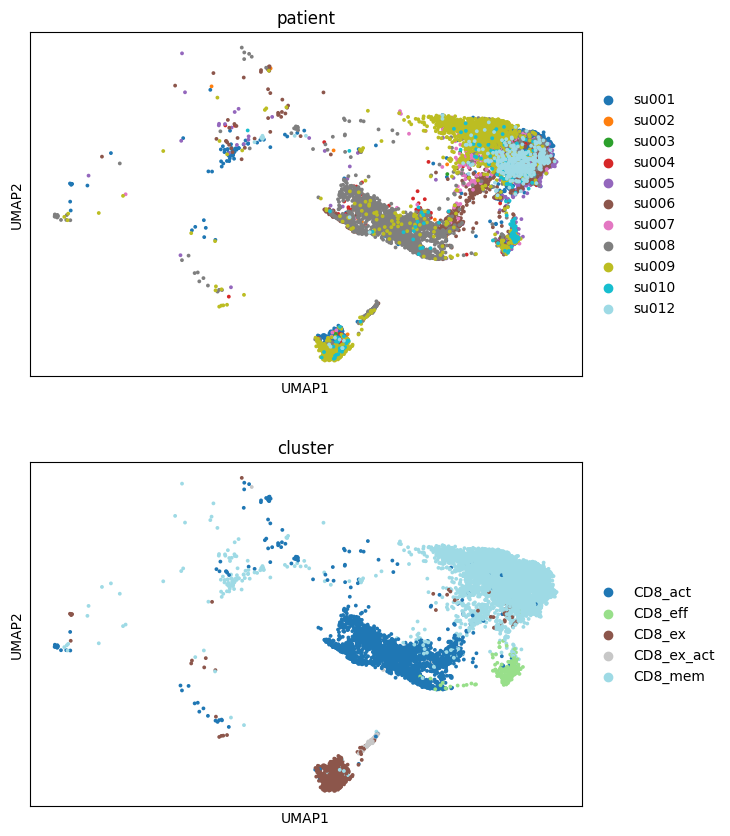

In [51]:
sc.pl.umap(adata,color=["patient","cluster","genevector"],s=30,wspace=0.2, ncols=1,palette="tab20")

100%|██████████| 9563/9563 [00:00<00:00, 74679.49it/s]


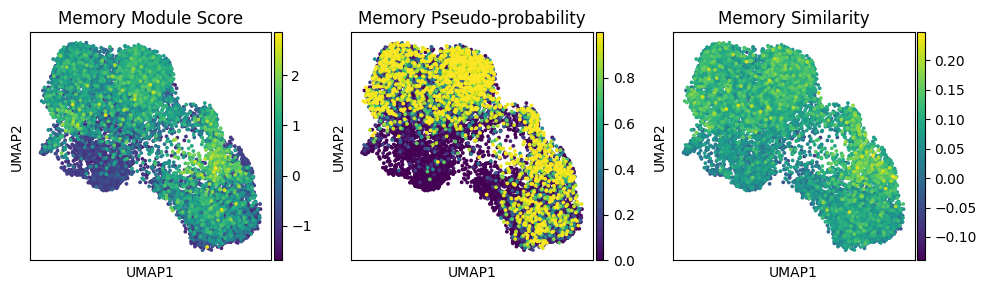

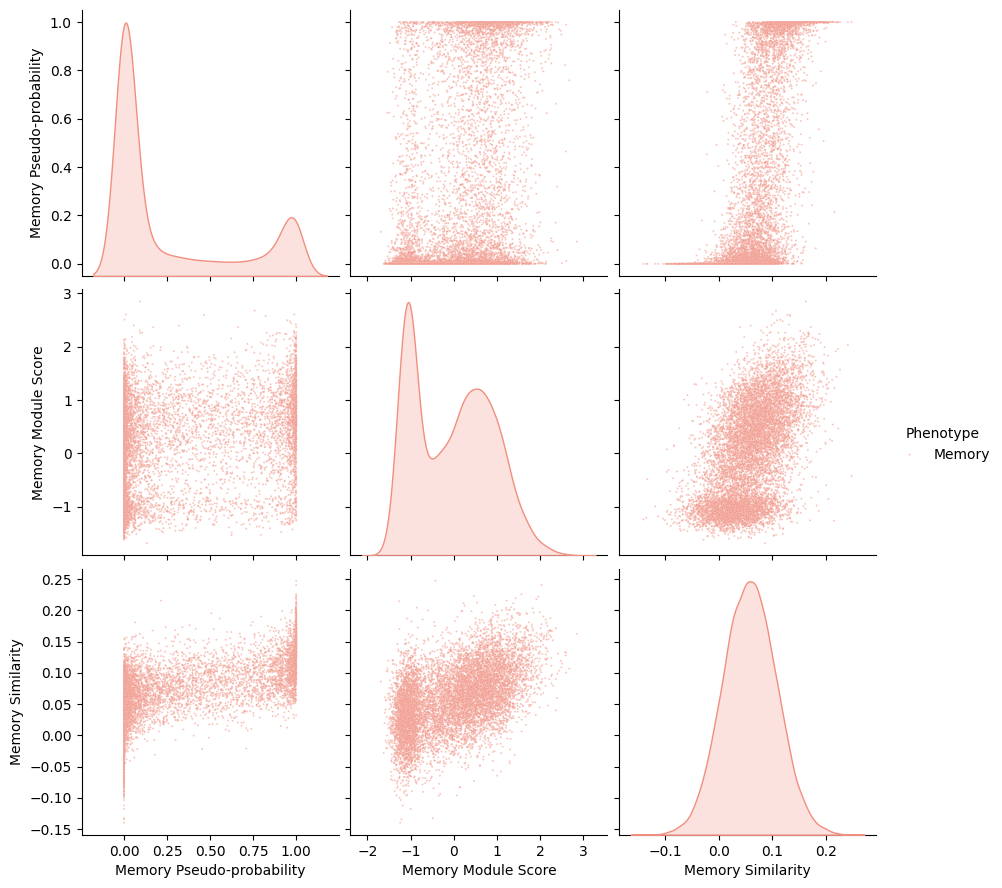

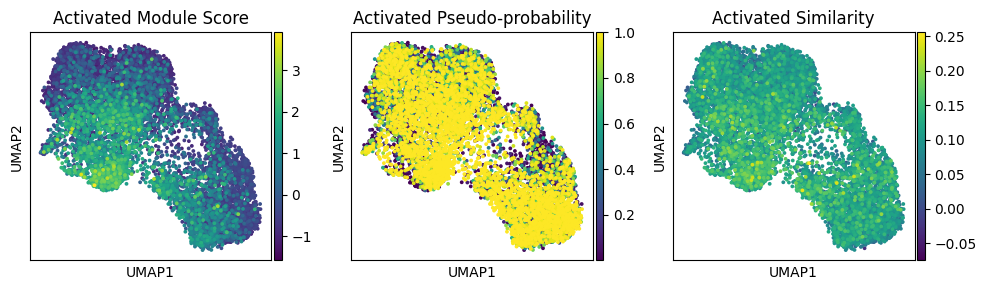

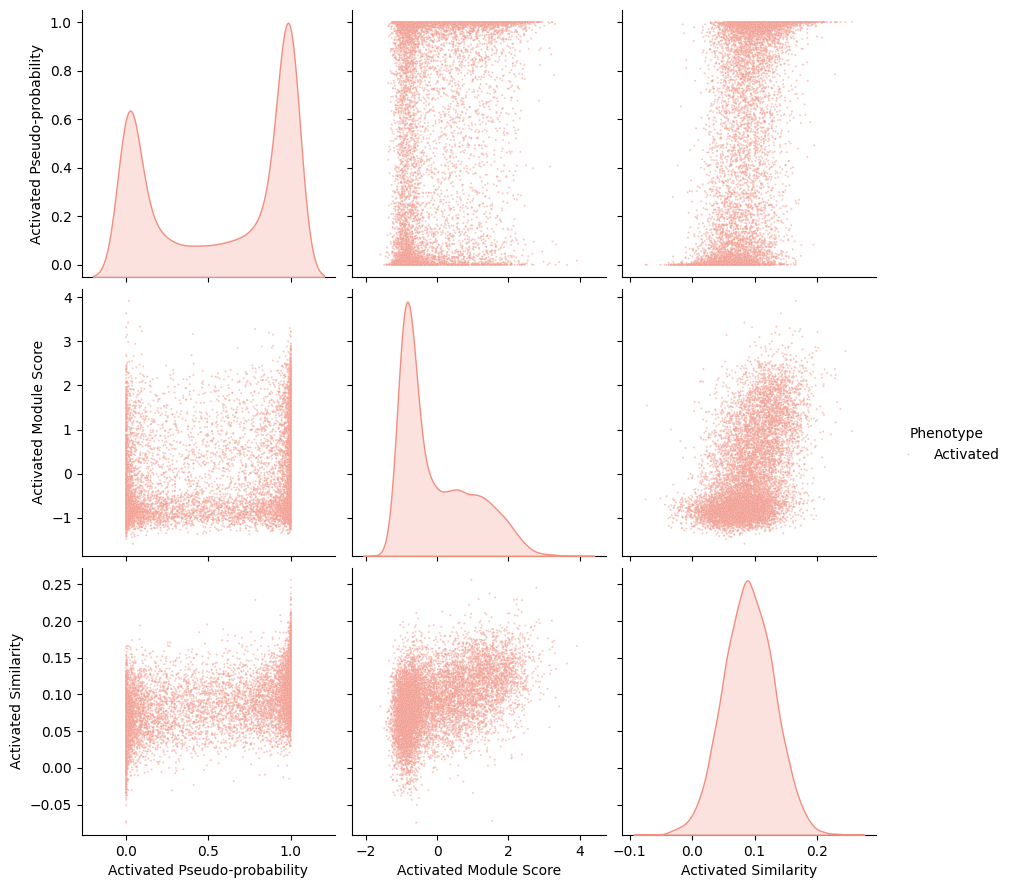

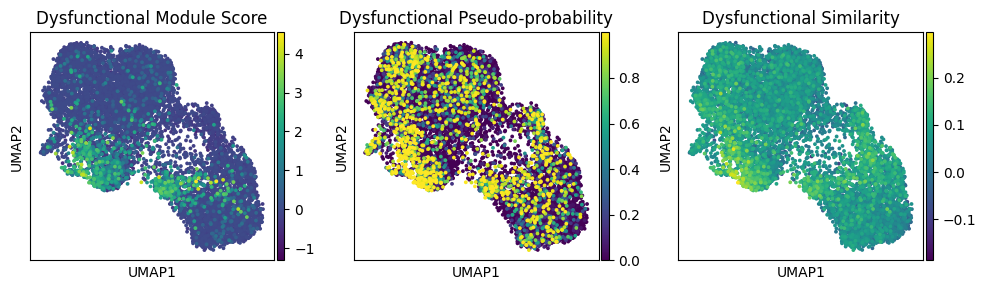

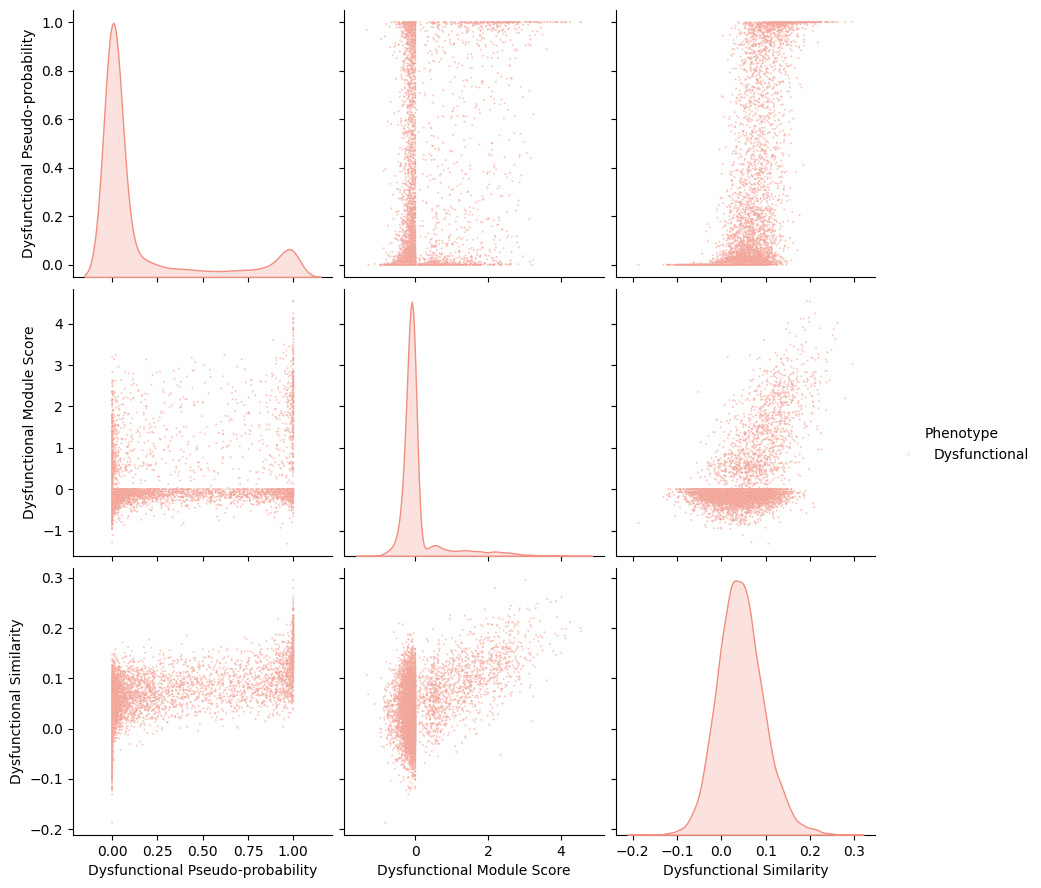

In [233]:
for phenotype, genes  in markers.items():
    cembed.phenotype_qc(adata,phenotype,genes)

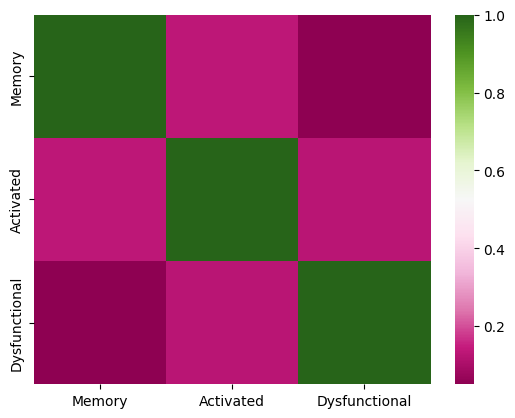

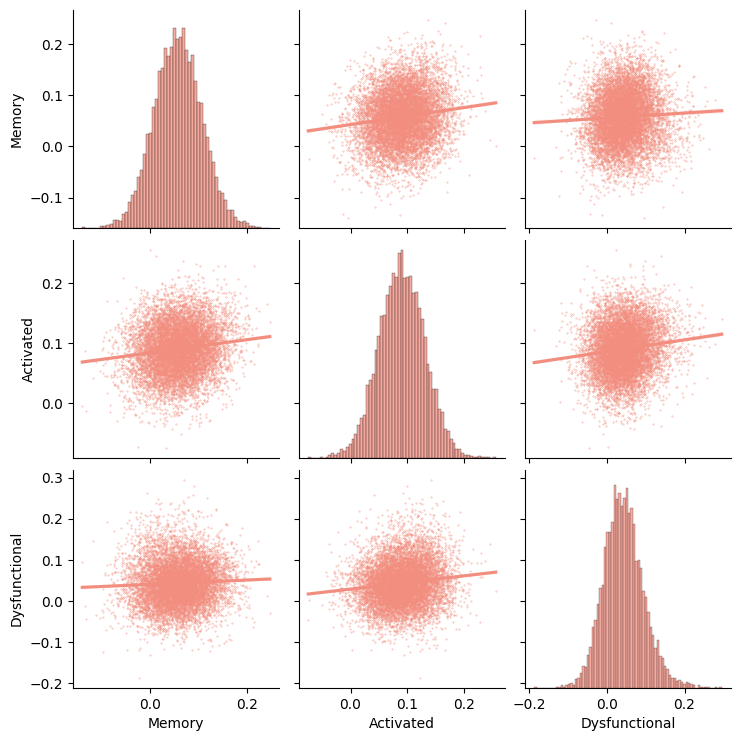

In [234]:
ddf = pd.DataFrame(data = np.array(dist["distances"]),columns=dist['order'])
mat = pd.DataFrame(np.corrcoef(ddf.to_numpy().T),index=dist["order"],columns=dist["order"])
sns.heatmap(mat,cmap="PiYG")
sns.pairplot(data=ddf,kind="reg",plot_kws={"scatter_kws":{"s":0.1}})

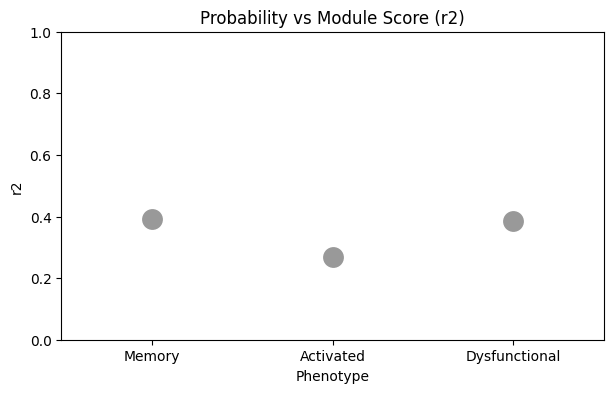

In [235]:
cembed.module_score_r2(adata,markers)

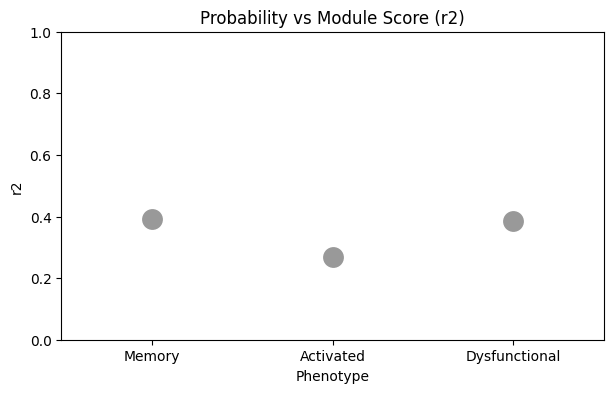

In [236]:
cembed.module_score_r2(adata,markers)

In [237]:
tcri.pp.register_phenotype_key(adata,"genevector")
tcri.pp.register_clonotype_key(adata,"trb")

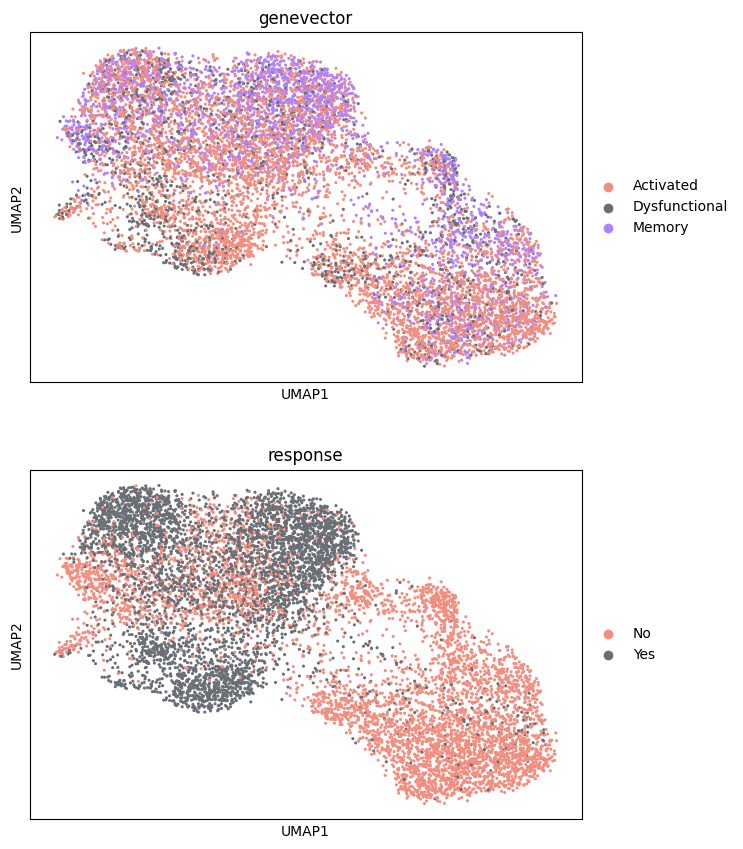

In [238]:
sc.pl.umap(adata,color=["genevector","response"],palette=tcri.pl.tcri_colors,s=20, wspace=0.2,ncols=1, save="bcc.pdf")
!cp figures/umapbcc.pdf ~

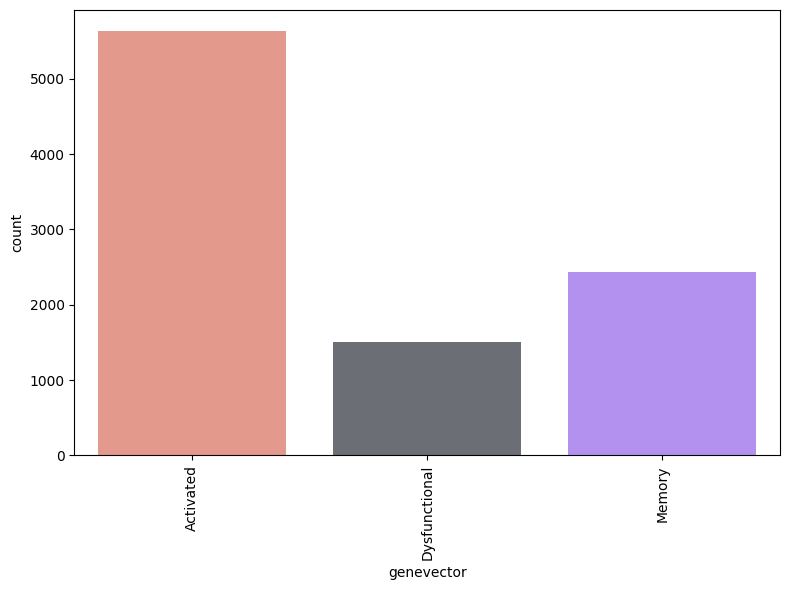

In [239]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
sns.countplot(data=adata.obs,x="genevector",palette=tcri.pl.tcri_colors,ax=ax)
plt.xticks(rotation=90)
fig.tight_layout()

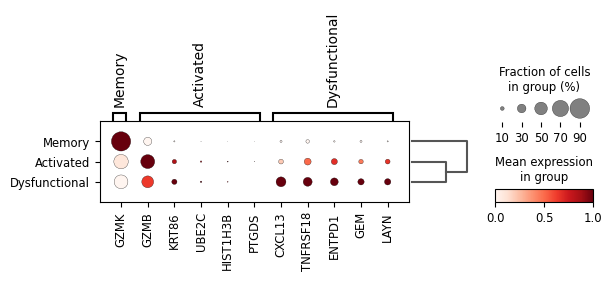

In [240]:
sc.tl.rank_genes_groups(adata,"genevector")
sc.tl.dendrogram(adata,"genevector")
sc.pl.rank_genes_groups_dotplot(adata,min_logfoldchange=1.,standard_scale='var',n_genes=5,save="tri_markers.pdf")
!cp figures/dotplot_tri_markers.pdf ~

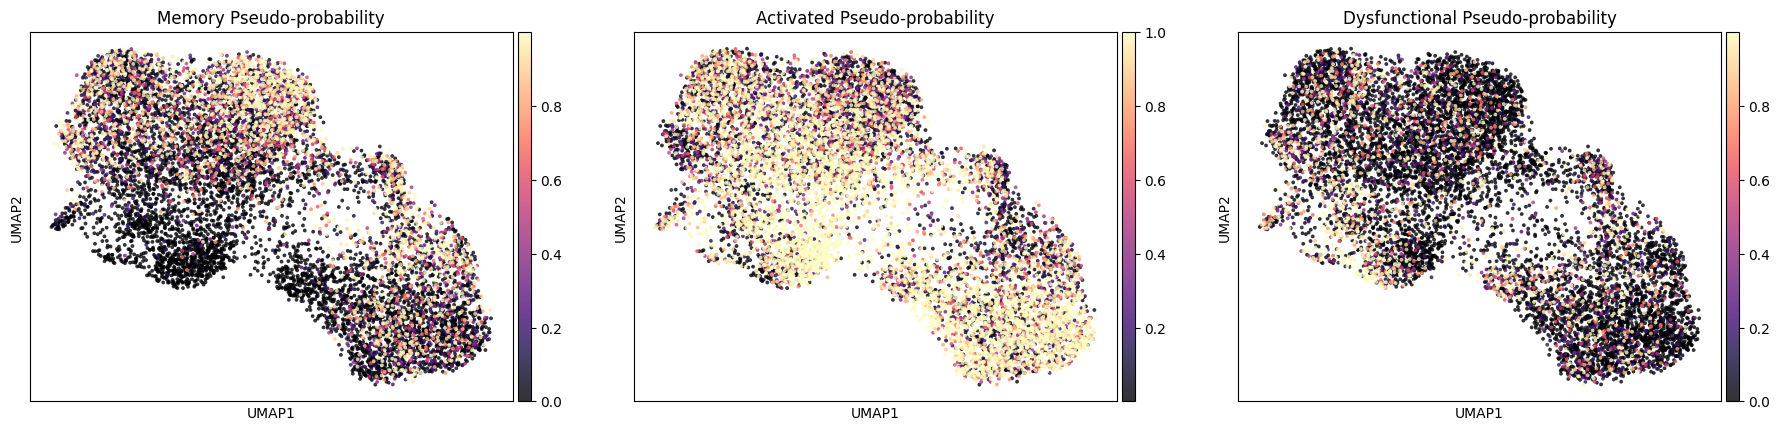

In [241]:

cembed.plot_probabilities(adata)
!cp figures/umapprobs.pdf ~

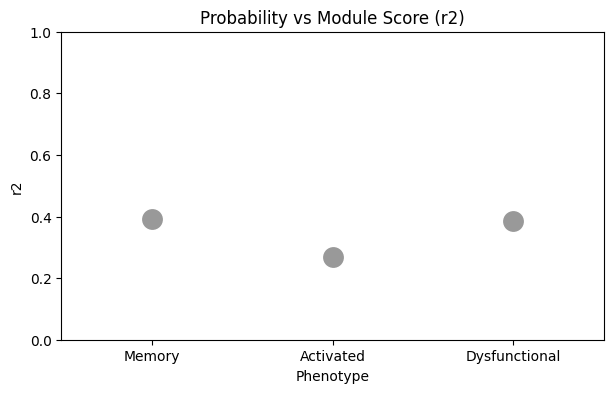

In [242]:
cembed.module_score_r2(adata,markers)

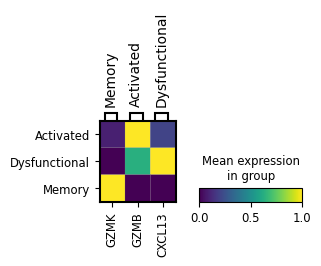

In [243]:
sc.pl.matrixplot(adata,markers,groupby="genevector",standard_scale="var")

In [244]:
from tcri.utils import *
def phenotypic_flux(adata, splitby, order, clones=None, normalize=True):
    phenotypes = Phenotypes(adata.obs[adata.uns["tcri_phenotype_key"]].unique())
    repertoires = dict()
    times = list(range(len(order)))
    for s in order:
        repertoires[s] = CellRepertoire(clones_and_phenos = {}, 
                                        phenotypes = phenotypes, 
                                        use_genes = False, 
                                        use_chain = False,
                                        seq_type = 'ntseq',
                                        chains_to_use = ['TRB'],
                                        name = s)
    for condition, seq, phenotype in zip(adata.obs[splitby],
                                         adata.obs[adata.uns["tcri_clone_key"]],
                                         adata.obs[adata.uns["tcri_phenotype_key"]]):
        if str(seq) != "nan" and condition in repertoires:
            repertoires[condition].cell_list.append(Tcell(phenotypes = phenotypes, 
                                                          phenotypes_and_counts = {phenotype: 1}, 
                                                          TRB = dict(aaseq = seq), 
                                                          use_genes = False))
    for condition, rep in repertoires.items():
        rep._set_consistency()
    fig, ax = plot_pheno_sankey(phenotypes = phenotypes, 
                                cell_repertoires = [repertoires[condition] for condition in order], 
                                clones = clones,
                                times = times,
                                xlim = [min(times), max(times)],
                                time_rescale = 1,
                                normalize=True,
                                xlabel = splitby,
                                return_axes = True, 
                                show_legend = True)
    ax.set_xticks(times)
    ax.set_xticklabels(order)
    fig.savefig("test.png")

In [245]:
tcri.pp.clone_size(adata)

In [246]:
s = []
r = []
e = []
for tcr, ent in tcri.tl.phenotypic_entropies(adata,normalized=False).items():
    response = adata[adata.obs['trb'] == tcr].obs['response'].tolist()
    response = list(set(response))[0]
    size = adata[adata.obs['trb'] == tcr].obs['clone_size'].tolist()
    size = list(set(size))[0]
    e.append(ent)
    s.append(size)
    r.append(response)
df = pd.DataFrame.from_dict({"Entropy":e, "Response":r, "Size": s})
df

Entropy Response  Size
0     0.228339      Yes     1
1     0.258506       No     1
2     0.830373       No     2
3     0.985135       No     2
4     0.000236       No     1
...        ...      ...   ...
3694  0.698869      Yes     1
3695  0.066374       No     1
3696  0.013005       No     1
3697  0.625340       No     1
3698  0.258052      Yes     2

[3699 rows x 3 columns]

<Axes: xlabel='Entropy', ylabel='Size'>

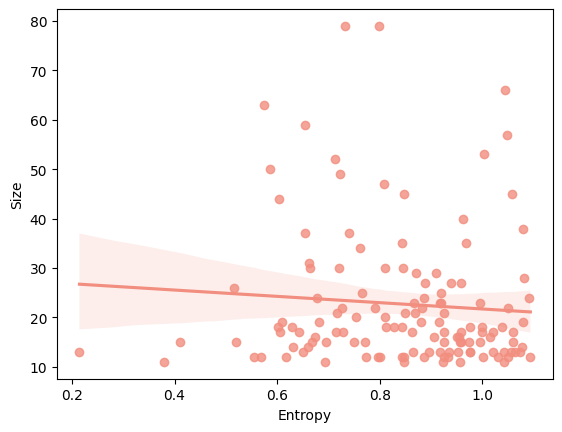

In [247]:
dfx=df[df["Size"]<80]
dfx=dfx[dfx["Size"] > 10]
sns.regplot(data=dfx,x='Entropy',y="Size")

2


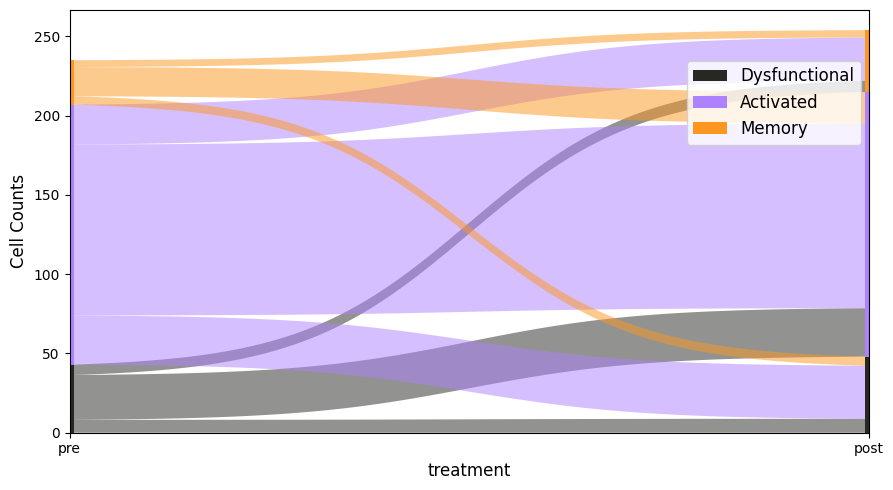

In [248]:
responder = adata[adata.obs["response"] == "Yes"]
responder = responder[responder.obs["clone_size"] >100]
print(len(set(responder.obs["trb"])))
tcri.pp.joint_distribution(responder)
tcri.pl.phenotypic_flux(responder,splitby="treatment",order=["pre","post"], normalize=False,nt=False)
plt.savefig("/Users/ceglian/resp_bcc.pdf")

3


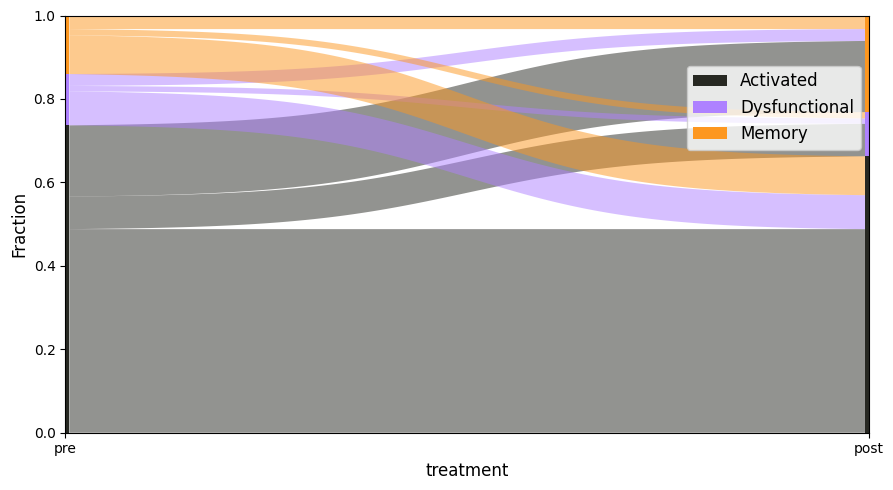

In [250]:
responder = adata[adata.obs["response"] == "No"]
responder = responder[responder.obs["clone_size"] > 60]
print(len(set(responder.obs["trb"])))
tcri.pp.joint_distribution(responder)
tcri.pl.phenotypic_flux(responder,splitby="treatment",order=["pre","post"],normalize=True,nt=False)
plt.savefig("/Users/ceglian/nresp_bcc.pdf")

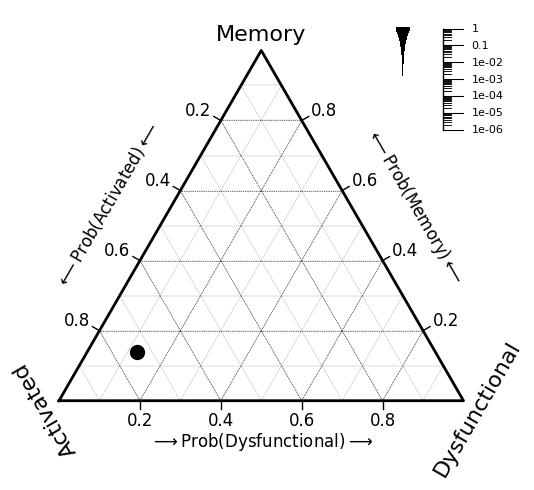

In [251]:
responder = adata[adata.obs["response"] == "No"]
responder = responder[responder.obs["clone_size"] > 60]
tcri.pl.ternary_plot(responder,phenotype_names=["Memory","Activated","Dysfunctional"],splitby="treatment",condition="post")
plt.savefig("/Users/ceglian/nresp_bcc_tern.pdf")

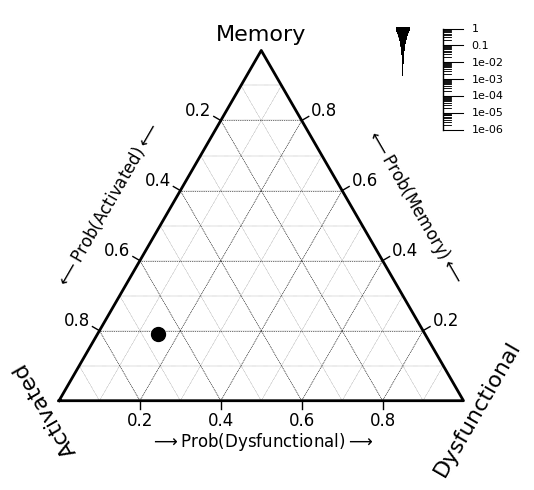

In [197]:
responder = adata[adata.obs["response"] == "Yes"]
responder = responder[responder.obs["clone_size"] > 60]
tcri.pp.joint_distribution(responder)
tcri.pl.ternary_plot(responder,phenotype_names=["Memory","Activated","Dysfunctional"],splitby="treatment",condition="post")
plt.savefig("/Users/ceglian/resp_bcc_tern.pdf")

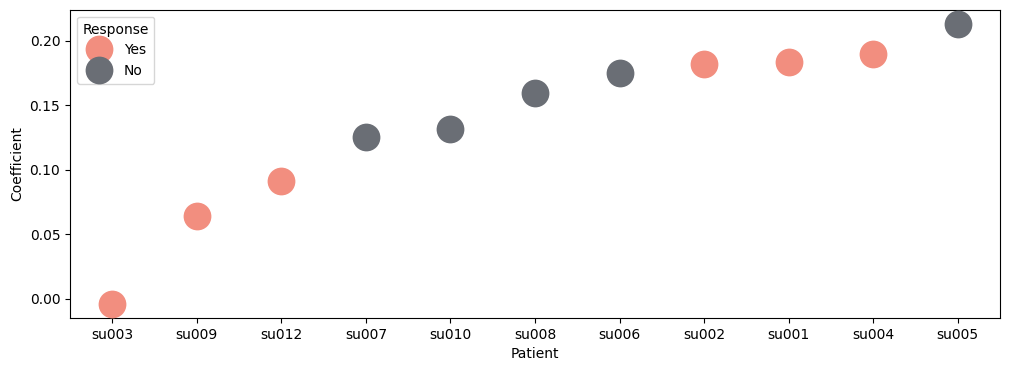

In [201]:
def phenotypic_entropies(adata, method="probabilistic", normalized=True):
    tcri.pp.joint_distribution(adata, method=method)
    tcr_sequences = adata.obs[adata.uns["tcri_clone_key"]].tolist()
    unique_tcrs = np.unique(tcr_sequences)
    jd = adata.uns["joint_distribution"].to_numpy() 
    jd = jd / np.sum(jd)
    clonotype_entropies = np.zeros(jd.shape[1])
    max_entropy = np.log(jd.shape[0])
    for i, clonotype_distribution in enumerate(jd.T):
        normalized_distribution = clonotype_distribution / np.sum(clonotype_distribution)
        epsilon = np.finfo(float).eps
        if normalized:
            clonotype_entropies[i] = -np.sum(normalized_distribution * np.log(normalized_distribution + epsilon)) / max_entropy
        else:
            clonotype_entropies[i] = -np.sum(normalized_distribution * np.log(normalized_distribution + epsilon))
    tcr_to_entropy_dict = dict(zip(unique_tcrs, clonotype_entropies))
    return tcr_to_entropy_dict


groupby = "patient"
ps = []
rs = []
r2 = []
for r in set(adata.obs["response"]):
    rdata = adata[adata.obs["response"] == r]
    for p in set(rdata.obs[groupby]):
        clone = []
        size = []
        ent = []
        pdata = rdata[rdata.obs[groupby] == p]
        ents = phenotypic_entropies(pdata)
        tcri.pp.clone_size(pdata)
        sizes = dict(zip(pdata.obs[pdata.uns["tcri_clone_key"]],pdata.obs["clone_size"]))
        for tcr,entropy in ents.items():
            ent.append(entropy)
            size.append(sizes[tcr])
            clone.append(tcr)
        df = pd.DataFrame.from_dict({"Entropy":ent,"Size":size,"TCR":clone})
        c = df["Entropy"].corr(df["Size"])
        ps.append(p)
        rs.append(r)
        r2.append(c)
df = pd.DataFrame.from_dict({"Patient":ps,"Response":rs,"Coefficient":r2})
df
fig, ax = plt.subplots(1,1,figsize=(12,4))
df = df.sort_values("Coefficient")
sns.stripplot(data=df, x="Patient",y="Coefficient",s=20, hue="Response",ax=ax)
fig.savefig("/Users/ceglian/phenotypic_entropy.pdf")

<Axes: title={'center': 'Clonotypic Entropy'}, xlabel='Phenotype', ylabel='Clonotypic Entropy'>

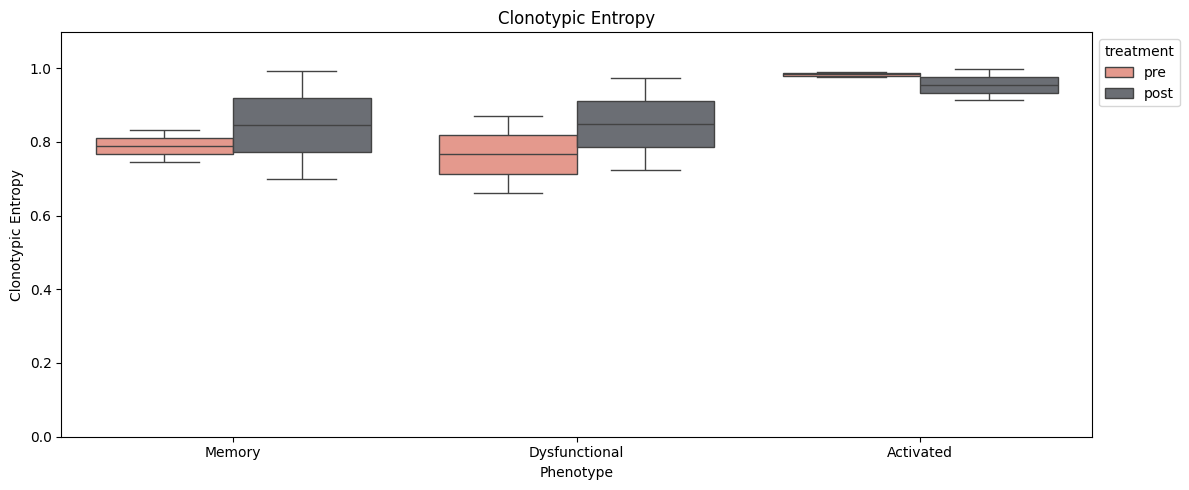

In [140]:
responder = adata[adata.obs["response"] == "Yes"]
responder = responder[responder.obs["clone_size"] > 50]
tcri.pl.clonotypic_entropies(responder, normalized=True, groupby="patient", splitby="treatment", method='probabilistic')

View of AnnData object with n_obs × n_vars = 1598 × 350
    obs: 'cell.id', 'patient', 'treatment', 'cluster', 'UMAP1', 'UMAP2', 'trb', 'trb2', 'disease', 'response', 'Size', 'TCR Sequence', 'genevector', 'Naive Similarity', 'Naive Module Score', 'Memory Similarity', 'Memory Module Score', 'Activated Similarity', 'Activated Module Score', 'Dysfunctional Similarity', 'Dysfunctional Module Score', 'clone_size', 'Memory Pseudo-probability', 'Activated Pseudo-probability', 'Dysfunctional Pseudo-probability'
    var: 'entropy'
    uns: 'cluster_colors', 'tcri_clone_key', 'tcri_unique_clonotypes', 'neighbors', 'umap', 'log1p', 'probability_columns', 'patient_colors', 'genevector_colors', 'tcri_unique_phenotypes', 'tcri_phenotype_key', 'rank_genes_groups', 'dendrogram_genevector', 'response_colors'
    obsm: 'X_umap', 'X_genevector', 'X_pca'
    obsp: 'distances', 'connectivities'


<Axes: title={'center': 'Clonotypic Entropy'}, xlabel='Phenotype', ylabel='Clonotypic Entropy'>

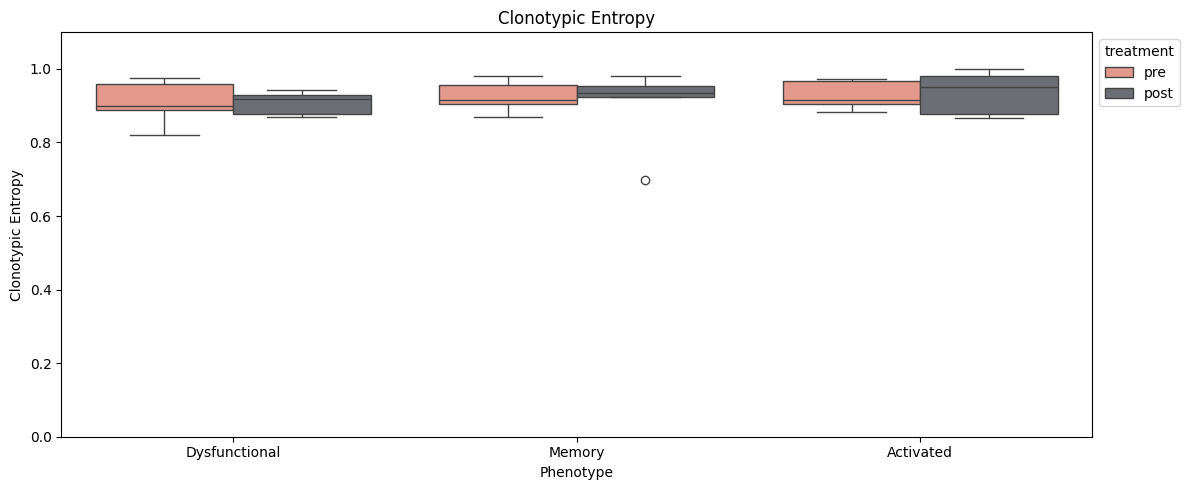

In [143]:
responder = adata[adata.obs["response"] == "No"]
responder = responder[responder.obs["clone_size"] > 10]
print(responder)
tcri.pl.clonotypic_entropies(responder, normalized=True, groupby="patient", splitby="treatment", method='probabilistic')

<Axes: title={'center': 'Clonality'}, xlabel='Phenotype', ylabel='Clonality'>

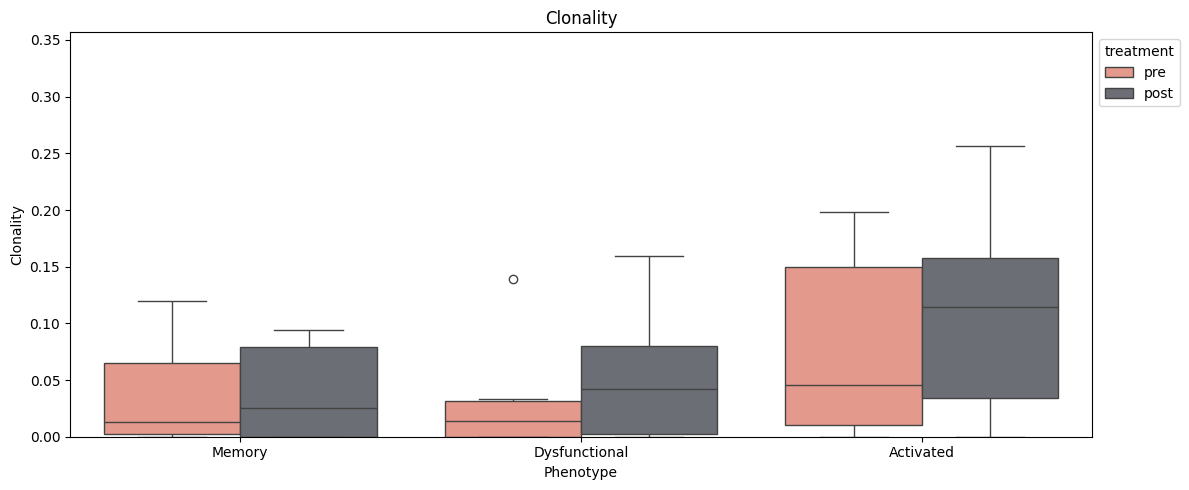

In [136]:
responder = adata[adata.obs["response"] == "Yes"]
tcri.pl.clonality(responder, groupby="patient",splitby="treatment")

<Axes: title={'center': 'Clonality'}, xlabel='Phenotype', ylabel='Clonality'>

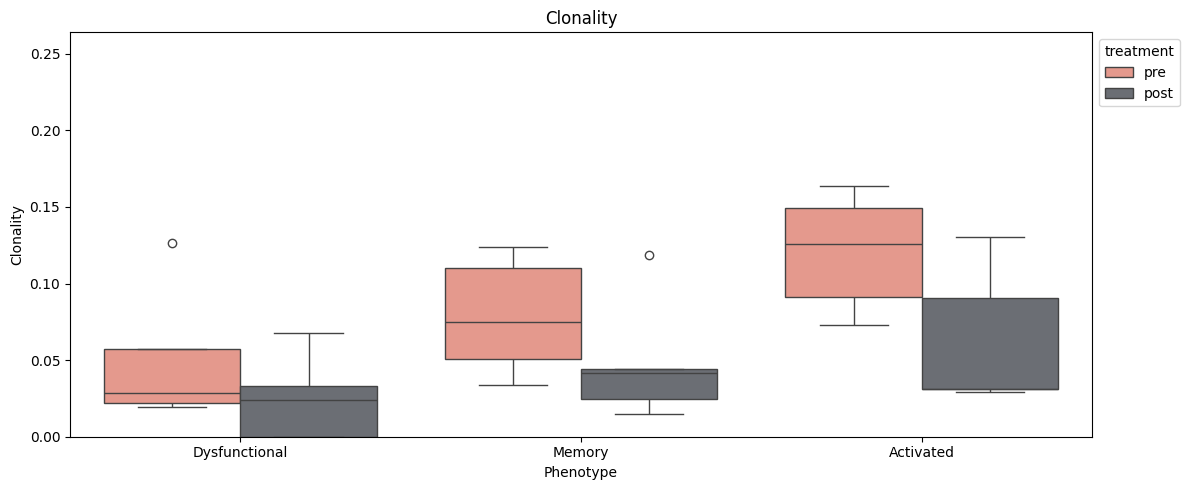

In [145]:
responder = adata[adata.obs["response"] == "No"]
tcri.pl.clonality(responder, groupby="patient",splitby="treatment")

<Axes: title={'center': 'Clonality'}, xlabel='Phenotype', ylabel='Clonality'>

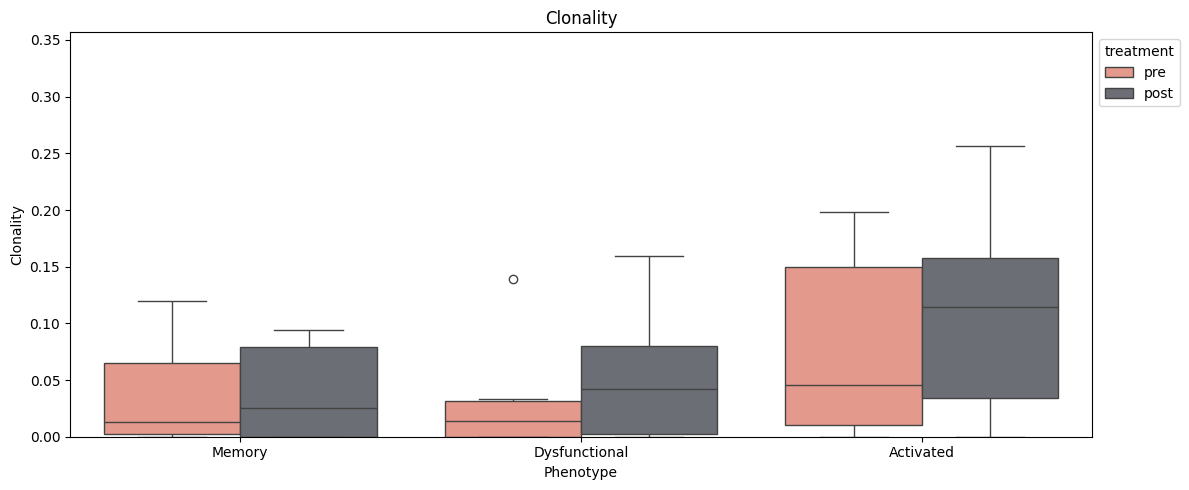

In [146]:
responder = adata[adata.obs["response"] == "Yes"]
tcri.pl.clonality(responder, groupby="patient",splitby="treatment")